In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from utils.array_to_df import using_multiindex

In [7]:

def individual_learning(R, p, m, rng):
    """
    Parameters:
    -----------
    R : int
        Number of independent universes
    p : float
        Probability of adopting the innovation
    m : np.ndarray (N,)
        Number of learning attempts
    """
    N = len(m)
    r = rng.random((R, N))
    s = 1.0 - (1.0 - p)**m
    disc = (r < s[None, :])
    return disc


def run_abm_batch(
    R=128, N=10_000, G=200, *, p=0.01, M=5, beta=3.0, Delta=1.0, tau=0.9,
    K=0, M_hi=None, machine_mode="none", seed=None
):
    """
    Vectorized ABM over R independent universes.
    g=1: first K agents are machines (M_hi); others are humans (M); exploration only.
    g>=2: social learning first (stochastic); non-adopters explore.

    Parameters:
    -----------
    machine_mode : str, default "none"
        Controls machine behavior across generations:
        - "none": No machines, all agents are humans
        - "first": First K agents are machines only in generation 1
        - "all": First K agents are machines in all generations

    Returns x with shape (R, G): adoption share per universe and generation (1..G).
    """
    rng = np.random.default_rng(seed)
    K = int(min(max(K, 0), N))
    M_hi = M if M_hi is None else int(M_hi)

    # Validate machine_mode parameter
    if machine_mode not in ["none", "first", "all"]:
        raise ValueError(f"machine_mode must be one of 'none', 'first', 'all', got '{machine_mode}'")

    c = np.exp(beta * Delta)

    a_prev = np.zeros((R, N), dtype=np.int8)
    x = np.empty((R, G), dtype=float)

    for g in range(1, G + 1):
        if G >= 2:
            # Social learning: pick a model category (1 vs 0) with softmax-based probability
            X_prev = a_prev.sum(axis=1).astype(float)                          # (R,)
            Pi = np.where(X_prev > 0.0, (c * X_prev) / (c * X_prev + (N - X_prev)), 0.0)
            choose1 = rng.random((R, N)) < Pi[:, None]                         # chose a model with action 1
            imitate = choose1 & (rng.random((R, N)) < tau)                     # successful imitation

        m = np.full(N, M)       
        if machine_mode == "all" or (machine_mode == "first" and G == 1):
            m[:K] = M_hi
        disc = individual_learning(R, p, m, rng)

        a_prev = disc | imitate
        x[:, g - 1] = a_prev.astype(float).mean(axis=1)

    return x

In [8]:
# -------- parameter grids: p, beta, tau, and exploration factor phi --------
p_vals = np.logspace(-8, -2, num=10)
beta_vals = np.linspace(0, 3, num=4)
tau_vals  = np.logspace(-1, 0, num=10)
phi_vals  = np.logspace(0, 4, num=5)
machine_modes = ["none", "first", "all"]
machine_modes = ['all']

print(p_vals)
print(beta_vals)
print(tau_vals)
print(phi_vals)

reference_beta = 0
reference_phi = 1.0
reference_mode = 'none'


# model constants and innovators
N, G, M = 100, 10, 100
K = 10          # number of first-generation innovators
Delta = 1.0     # reward gap
R = 1000

results = np.empty((len(machine_modes), len(p_vals), len(beta_vals), len(tau_vals), len(phi_vals)))

print("Start calculating...")

for mode_idx, machine_mode in enumerate(machine_modes):
    for i, p in enumerate(p_vals):
        for j, beta in enumerate(beta_vals):
            for k, tau in enumerate(tau_vals):
                for l, phi in enumerate(phi_vals):
                    if (beta != reference_beta) and (phi != reference_phi): # and (machine_mode != reference_mode):
                        continue
                    M_hi = int(np.ceil(phi * M))
                    x = run_abm_batch(R=R, N=N, G=G, p=p, M=M, beta=beta, Delta=Delta, tau=tau, machine_mode=machine_mode,
                                K=K, M_hi=M_hi)
                    results[mode_idx, i, j, k, l] = x[-1].mean(axis=0)  # final adoption share


[1.00000000e-08 4.64158883e-08 2.15443469e-07 1.00000000e-06
 4.64158883e-06 2.15443469e-05 1.00000000e-04 4.64158883e-04
 2.15443469e-03 1.00000000e-02]
[0. 1. 2. 3.]
[0.1        0.12915497 0.16681005 0.21544347 0.27825594 0.35938137
 0.46415888 0.59948425 0.77426368 1.        ]
[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
Start calculating...


In [9]:
df = using_multiindex(results, ['machine_mode', 'p', 'beta', 'tau', 'phi'])

results = None

df['phi'] = df['phi'].map(lambda x: phi_vals[x])
df['beta'] = df['beta'].map(lambda x: beta_vals[x])
df['tau'] = df['tau'].map(lambda x: tau_vals[x])
df['lambda'] = 1 - df['tau']
df['p'] = df['p'].map(lambda x: p_vals[x])
df['machine_mode'] = df['machine_mode'].map(lambda x: machine_modes[x])


<Axes: xlabel='lambda', ylabel='p'>

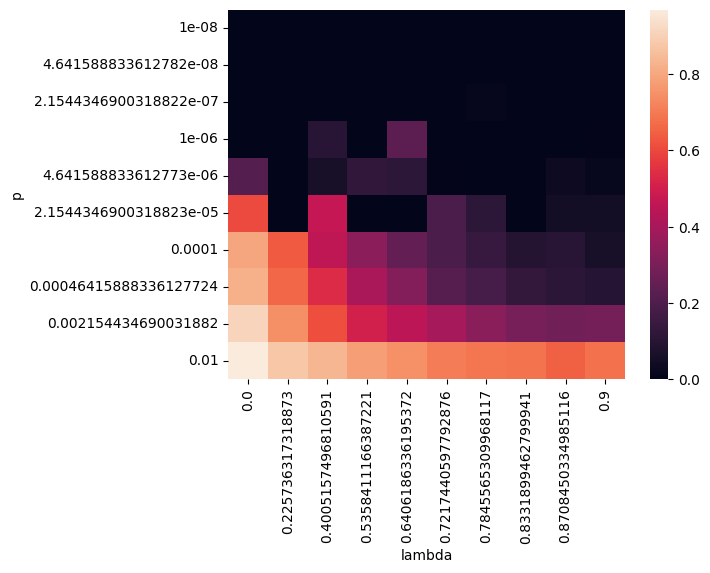

In [10]:
dfs = df[(df['phi'] == reference_phi) & (df['beta'] == 3) & (df['machine_mode'] == 'all')]

dfs = dfs.groupby(['p', 'lambda'])['value'].mean().reset_index()

m = dfs.pivot(index='p', columns='lambda', values='value')

sns.heatmap(m)

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from typing import Optional, Sequence


def contourplot(
    data: pd.DataFrame,
    x: str,
    y: str,
    z: str,
    hue: Optional[str] = None,
    style: Optional[str] = None,
    levels: Optional[Sequence[float]] = None,
    log_y: bool = False,
    ax: Optional[plt.Axes] = None,
    palette: Optional[Sequence[str]] = None,
    linestyles: Optional[Sequence[str]] = None,
    reverse_y: bool = True,
    linewidths: Optional[float] = None,
    **kwargs,
) -> plt.Axes:
    """
    Seaborn-like contour plot for long-form data, with optional hue and style.
    Draws one contour set per hue level and builds a robust legend via proxy artists.

    Parameters:
    -----------
    data : pd.DataFrame
        Long-form data with columns for x, y, z, and optional hue/style
    x : str
        Column name for x-axis values
    y : str
        Column name for y-axis values
    z : str
        Column name for z values (contour levels)
    hue : str, optional
        Column name for color grouping
    style : str, optional
        Column name for line style grouping
    levels : sequence, optional
        Contour levels to draw
    log_y : bool, default False
        Whether to use log scale for y-axis
    ax : plt.Axes, optional
        Axes to plot on
    palette : sequence, optional
        Colors to use for hue levels
    linestyles : sequence, optional
        Line styles to use for style levels (e.g., ['-', '--', '-.', ':'])
    reverse_y : bool, default True
        Whether to reverse y-axis
    linewidths : float, optional
        Width of contour lines
    **kwargs
        Additional arguments passed to ax.contour()
    """
    if ax is None:
        _, ax = plt.subplots()

    # Normalize grouping for hue
    if hue is None:
        hue_levels = [None]
    else:
        hue_levels = list(pd.unique(data[hue]))

    # Normalize grouping for style
    if style is None:
        style_levels = [None]
    else:
        style_levels = list(pd.unique(data[style]))

    # Choose colors: one per hue level
    if palette is None:
        palette = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0"])
    colors_for_hue = [palette[i % len(palette)] for i in range(len(hue_levels))]

    # Choose line styles: one per style level
    if linestyles is None:
        linestyles = ['-', '--', '-.', ':']
    styles_for_style = [linestyles[i % len(linestyles)] for i in range(len(style_levels))]

    # Use a consistent linewidth for proxies and contours
    lw_for_handles = linewidths if linewidths is not None else kwargs.get("linewidths", None)

    # Collect proxies for legend
    legend_handles = []
    legend_labels = []

    # Iterate over all combinations of hue and style
    for h_idx, h in enumerate(hue_levels):
        for s_idx, s in enumerate(style_levels):
            # Filter data for this hue-style combination
            df = data.copy()
            if h is not None:
                df = df[df[hue] == h]
            if s is not None:
                df = df[df[style] == s]

            if df.empty:
                continue

            # Get color and style for this combination
            color = colors_for_hue[h_idx]
            linestyle = styles_for_style[s_idx]

            # Pivot to grid
            mat = df.pivot(index=y, columns=x, values=z).sort_index(axis=0, ascending=False).sort_index(axis=1)

            X, Y, Z = mat.columns.values, mat.index.values, mat.values
            Y, Z = Y[::-1], Z[::-1, :]

            # Draw contours for this hue-style combination
            ax.contour(
                X, Y, Z,
                levels=levels,
                colors=color,
                linestyles=linestyle,
                linewidths=linewidths,
                antialiased=True,
                **kwargs,
            )

            # Build proxy lines for the legend
            label_parts = []
            if h is not None:
                label_parts.append(f"{hue}={h}")
            if s is not None:
                label_parts.append(f"{style}={s}")

            if label_parts:
                label = ", ".join(label_parts)
                handle = Line2D([], [], color=color, linestyle=linestyle,
                              linewidth=lw_for_handles if lw_for_handles is not None else 1.5)
                legend_handles.append(handle)
                legend_labels.append(label)

    # Create legend if we have handles
    if legend_handles:
        legend_title = None
        if hue is not None and style is not None:
            legend_title = f"{hue}, {style}"
        elif hue is not None:
            legend_title = hue
        elif style is not None:
            legend_title = style
        ax.legend(handles=legend_handles, labels=legend_labels, title=legend_title)

    if log_y:
        ax.set_yscale("log")

    ax.invert_yaxis()
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return ax


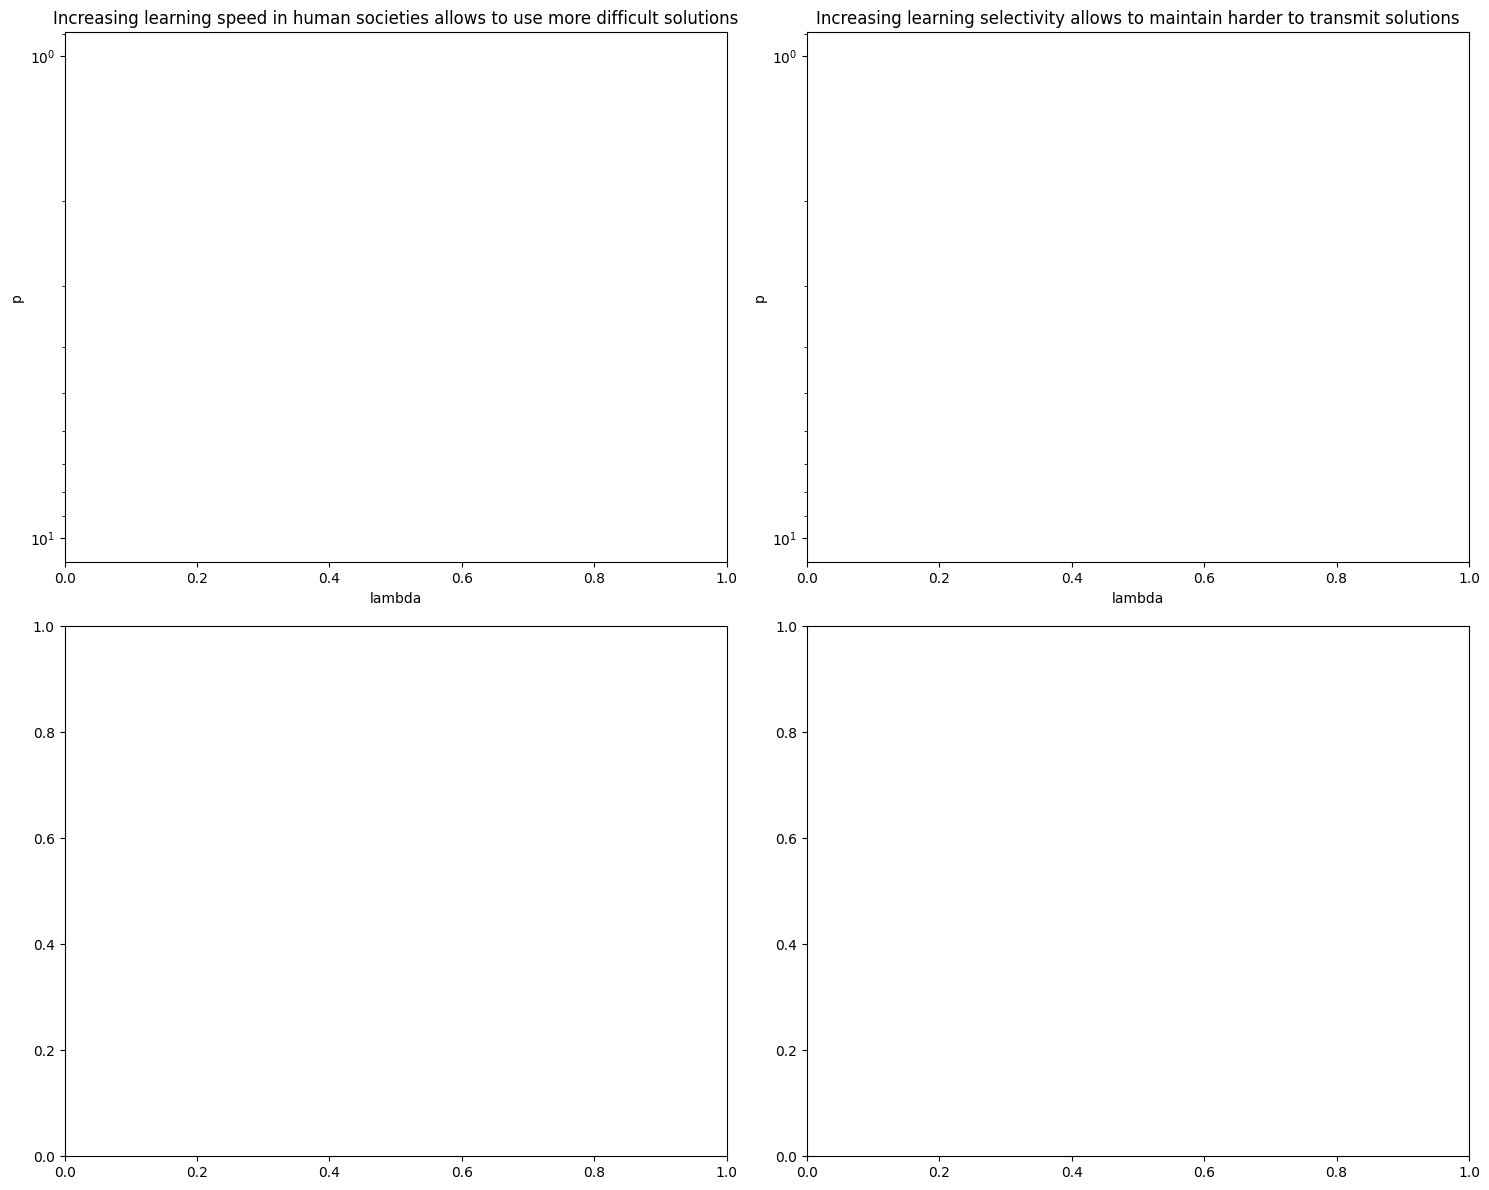

In [12]:
# Create two contour plots as subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]

dfs = df[(df['beta'] == reference_beta) & (df['machine_mode'] == reference_mode)]
dfs = dfs.groupby(['p', 'lambda', 'phi', 'beta', 'machine_mode']).mean().reset_index()
contourplot(dfs, 'lambda', 'p', 'value', hue='phi', levels=[0.5], log_y=True,
            ax=ax1, reverse_y=True)
ax1.set_title(f'Increasing learning speed in human societies allows to use more difficult solutions')


dfs = df[(df['phi'] == reference_phi) & (df['machine_mode'] == reference_mode)]
dfs = dfs.groupby(['p', 'lambda', 'phi', 'beta', 'machine_mode']).mean().reset_index()
contourplot(dfs, 'lambda', 'p', 'value', hue='beta', levels=[0.5], log_y=True,
            ax=ax2, reverse_y=True)
ax2.set_title(f'Increasing learning selectivity allows to maintain harder to transmit solutions')

# # Plot 2: Fixed beta = reference_beta
# dfs_lambda = df[(df['beta'] == reference_beta) & (df['machine_mode'] == reference_mode)]
# dfs_lambda = dfs_lambda.groupby(['p', 'lambda', 'phi', 'machine_mode']).mean().reset_index()
# contourplot(dfs_lambda, 'lambda', 'p', 'value', hue='phi', levels=[0.5], log_y=True,
#             ax=ax2, reverse_y=True)
# ax2.set_title(f'Increasing Exploration Rate Allows for Increasingly Difficult Solutions')

# # Plot 3: Fixed beta = reference_beta
# dfs_lambda = df[(df['beta'] == reference_beta) & (df['phi'] == reference_phi)]
# dfs_lambda = dfs_lambda.groupby(['p', 'lambda', 'machine_mode']).mean().reset_index()
# contourplot(dfs_lambda, 'lambda', 'p', 'value', hue='machine_mode', levels=[0.5], log_y=True,
#             ax=ax3, reverse_y=True)
# ax3.set_title(f'Fixed β = {reference_beta}')

plt.tight_layout()
plt.show()
